In [28]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [29]:
words = open("names.txt", "r").read().splitlines()
words[0:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [30]:
unique_chars = set("".join(list(word for word in words)))
mp = {ch:indx + 1 for indx, ch in enumerate(sorted(unique_chars))}
mp["."] = 0
mp_rev = {indx: ch for ch, indx in mp.items()}
print(mp_rev[0])

.


In [31]:
# build the dataset
block_size = 16 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = mp[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
xs_train, ys_train  = build_dataset(words[:n1])     # 80%
xs_val, ys_val = build_dataset(words[n1:n2])   # 10%
xs_test, ys_test  = build_dataset(words[n2:])     # 10%

torch.Size([182778, 16]) torch.Size([182778])
torch.Size([22633, 16]) torch.Size([22633])
torch.Size([22735, 16]) torch.Size([22735])


In [32]:
class Linear:
    def __init__(self, in_features, out_features, bias=True):
        self.W = torch.randn((in_features, out_features)) / (in_features ** 0.5)
        self.b = torch.zeros(out_features) if bias else None
    def __call__(self, x):
        self.out = x @ self.W
        if self.b is not None:
            self.out += self.b
        return self.out
    def parameters(self):
        return [self.W] + ([] if self.b is None else [self.b])
class Tanh:
    def __call__(self, h):
        self.out = torch.tanh(h)
        return self.out
    def parameters(self):
        return []
class BatchNorm1D:
    def __init__(self, num_features, eps=1e-05, momentum=0.1):
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        # Trainable 
        self.gamma = torch.ones(num_features)
        self.beta = torch.zeros(num_features)
        # Non Trainanble
        self.running_var = torch.ones(num_features)
        self.running_mean = torch.zeros(num_features)
        self.training = True

    def __call__(self, x):
        curr_mean = x.mean((0, 1), keepdim=True)
        curr_var = x.var((0, 1), keepdim=True)
        out1 = None
        if self.training:
            out1 = (x - curr_mean) / torch.sqrt(curr_var + self.eps)
        else:
            out1 = (x - self.running_mean) / torch.sqrt(self.running_var + self.eps) 
        self.out = self.gamma * out1 + self.beta
        if self.training:
            with torch.no_grad():
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * curr_var
                self.runnig_mean = (1 - self.momentum) * self.running_mean + self.momentum * curr_mean
        return self.out
                                      
    def parameters(self):
        return [self.gamma, self.beta]

class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.all_emb = torch.randn((num_embeddings, embedding_dim))
    def __call__(self, idx):
        self.out = self.all_emb[idx]
        return self.out
    def parameters(self):
        return [self.all_emb]

class Flatten:
    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out
    def parameters(self):
        return []

class FlattenConsecutive:
    def __init__(self, n):
        self.n = n
    def __call__(self, x):
        N, L, C = x.shape
        self.out = x.view(N, L//self.n, C*self.n)
        if self.out.shape[1] == 1:
            self.out = torch.squeeze(self.out, 1)
        return self.out
    def parameters(self):
        return []

class Sequential:
    def __init__(self, layers):
        self.layers = layers
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    

In [33]:
# Initialize variables and declare model layers
emb_dim = 20
n_hidden = 100
vocab_size = 27
consecutive_merge = 2
# layers = [Linear(emb_dim * block_size, n_hidden), Tanh(), 
#           Linear(n_hidden, n_hidden), Tanh(), 
#           Linear(n_hidden, n_hidden), Tanh(), 
#           Linear(n_hidden, n_hidden), Tanh(), 
#           Linear(n_hidden, n_hidden), Tanh(), 
#           Linear(n_hidden, vocab_size)]

model = Sequential([Embedding(vocab_size, emb_dim), FlattenConsecutive(consecutive_merge), Linear(emb_dim * consecutive_merge, n_hidden, False), BatchNorm1D(num_features=n_hidden), Tanh(), 
          FlattenConsecutive(consecutive_merge), Linear(n_hidden * consecutive_merge, n_hidden, False), BatchNorm1D(num_features=n_hidden), Tanh(), 
          FlattenConsecutive(consecutive_merge), Linear(n_hidden * consecutive_merge, n_hidden, False), BatchNorm1D(num_features=n_hidden), Tanh(), 
          FlattenConsecutive(consecutive_merge), Linear(n_hidden * consecutive_merge, n_hidden, False), BatchNorm1D(num_features=n_hidden), Tanh(), 
          Linear(n_hidden, vocab_size, False), BatchNorm1D(num_features=vocab_size)])

# Turn on requires_grad value for all the parameters
print(sum(p.nelement() for p in model.parameters()))
for parameter in model.parameters():
    parameter.requires_grad = True

68094


In [34]:
with torch.no_grad():
    # 1. Make last linear layer less confident so that initial spikes got cut off and model spend more time on minimizing actual loss
    # layers[-1].W *= 0.1
    model.layers[-1].gamma *= 0.1
    
    # 2. As we are using tanh and not using normalization we should use the scale factor 5/3 for all the linear layers followed by tanh layer so that
    # after applying tanh output remains gaussian distributed 
    
    for layer in model.layers[0:-1]:
        if isinstance(layer, Linear):
            layer.W *= 5/3

    

In [49]:

# Training loop 
max_iter = 100000
batch_size = 32
lr = 0.03
losses = []
ud = []
for i in range(max_iter):
    idx = torch.randint(0, xs_train.shape[0], (batch_size, ))
    logits = model(xs_train[idx])
    loss = F.cross_entropy(logits, ys_train[idx])
    for layer in model.layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in model.parameters():
        p.grad = None
    loss.backward()
    for p in model.parameters():
        p.data -= lr * p.grad
    losses.append(loss.item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in model.parameters()])

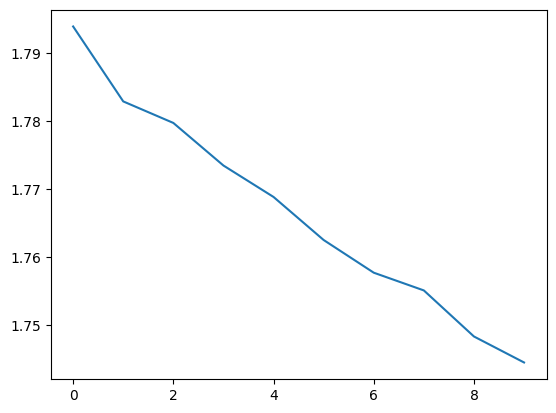

In [50]:
losses = torch.tensor(losses)
losses.shape
plt.plot(losses.view(10, -1).mean(1))
plt.show()

layer 4 (      Tanh): mean -0.00, std 0.71, saturated: 12.70%
layer 8 (      Tanh): mean -0.01, std 0.96, saturated: 63.73%
layer 12 (      Tanh): mean -0.02, std 0.92, saturated: 59.00%
layer 16 (      Tanh): mean -0.05, std 0.89, saturated: 57.69%


Text(0.5, 1.0, 'activation distribution')

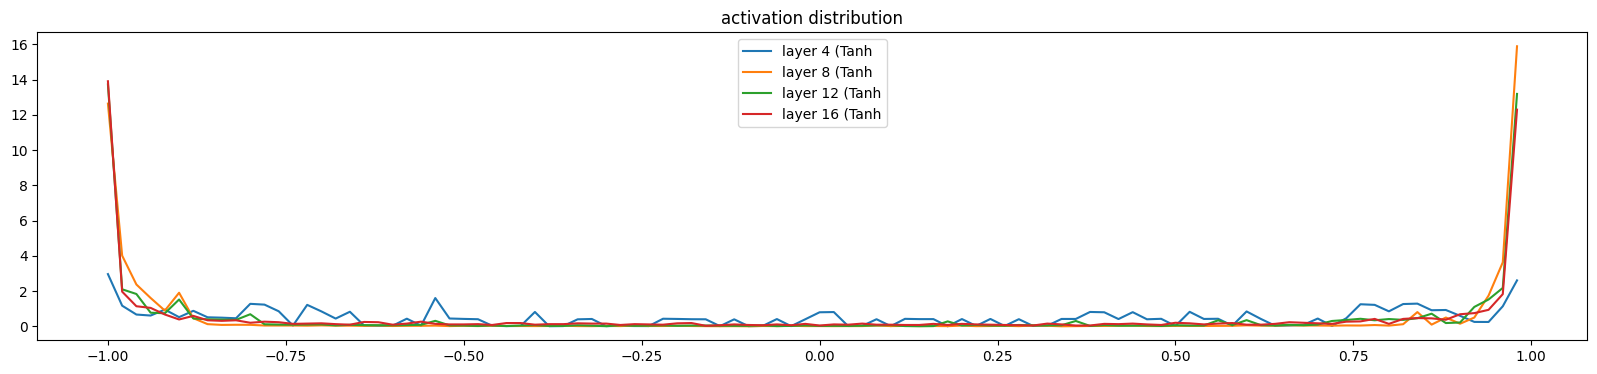

In [51]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(model.layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 4 (      Tanh): mean -0.000019, std 2.599578e-03
layer 8 (      Tanh): mean -0.000009, std 3.387512e-03
layer 12 (      Tanh): mean -0.000031, std 3.758046e-03
layer 16 (      Tanh): mean +0.000032, std 5.327781e-03


Text(0.5, 1.0, 'gradient distribution')

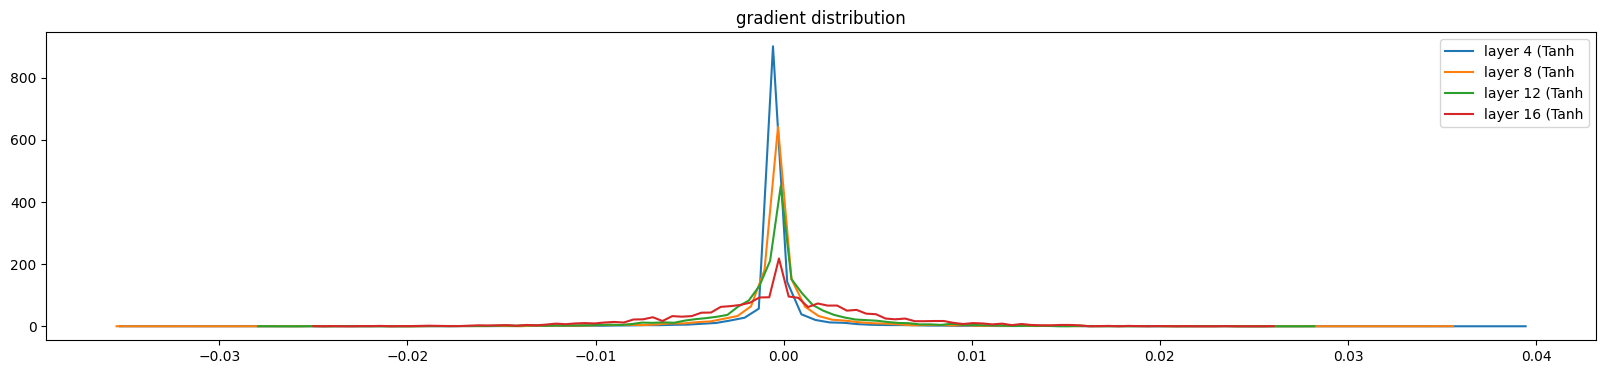

In [52]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(model.layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

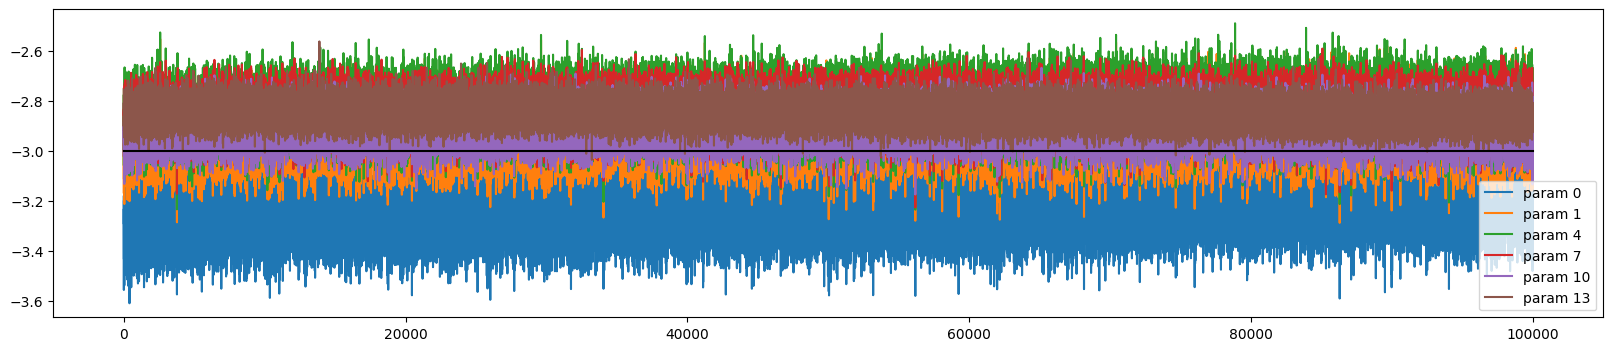

In [53]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(model.parameters()):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [54]:
for layer in model.layers:
    layer.training = False

In [55]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (xs_train, ys_train),
    'val': (xs_val, ys_val),
    'test': (xs_test, ys_test),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

# put layers into eval mode
for layer in model.layers:
  layer.training = False
split_loss('train')
split_loss('val')
split_loss('test')

train 1.7451889514923096
val 2.341029167175293
test 2.400953769683838


In [15]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      x = torch.tensor([context])
      logits = model(x)
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(mp_rev[i] for i in out)) # decode and print the generated word

lthani.
yazliee.
madhryah.
leisaslend.
liz.
lizhad.
tliizlyn.
jeulah.
livana.
arayatzi.
zlyan.
nyshab.
zlihimaes.
liztoniel.
lanter.
fiustance.
rhylynn.
elayna.
jaysanya.
zhal.
